In [1]:
!pip install qutip numpy matplotlib cvxpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 35.9 MB/s eta 0:00:00


# CVXPy Implementation

In [72]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [73]:
# Define the set of monomials in the moment matrix (Level 1 NPA)
# Each monomial is a string representing a product of measurement labels
monomials = ["", "A0", "A1", "B0", "B1", "A0B0", "A0B1", "A1B0", "A1B1"]
mono_index = {m: i for i, m in enumerate(monomials)}
n = len(monomials)

In [74]:
# This is the Gram Matrix -> Check Watrous for more info
# This shit is already PSD -> Hermitian -> Symmetric so cvxpy
# reads this to be a symmetric matrix already so no worries there
Gamma = cp.Variable((n, n), PSD=True)
constraints = []
# Normalization: <1|1> = 1
constraints.append(Gamma[mono_index[""], mono_index[""]] == 1)

# Projectors: A0^2 = A1^2 = B0^2 = B1^2 = I ⇒ <X|X> = 1
for op in ["A0", "A1", "B0", "B1"]:
    idx = mono_index[op]
    constraints.append(Gamma[idx, idx] == 1)

for Ai in ["A0", "A1"]:
    for Bj in ["B0", "B1"]:
        i, j = mono_index[Ai], mono_index[Bj]
        ab = mono_index[Ai + Bj]
        constraints.append(Gamma[i, j] == Gamma[0, ab])

## Objective Function

In [75]:
# Objective: maximize CHSH value
# CHSH = ⟨A0B0⟩ + ⟨A0B1⟩ + ⟨A1B0⟩ - ⟨A1B1⟩
chsh = (Gamma[0, mono_index["A0B0"]] +
        Gamma[0, mono_index["A0B1"]] +
        Gamma[0, mono_index["A1B0"]] -
        Gamma[0, mono_index["A1B1"]])

## Define the problem and solve it

In [76]:
problem = cp.Problem(cp.Maximize(chsh), constraints)
problem.solve()

np.float64(2.828427423712484)

In [77]:
print(f"Maximum quantum CHSH value (via SDP): {problem.value:.6f}")


Maximum quantum CHSH value (via SDP): 2.828427


# Varying the $\theta$ values for partially entangled states

In [78]:
# Pauli matrices
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

In [79]:
# kron of two 2x2 matrices (numpy)
def kron(A,B):
    return np.kron(A,B)


In [80]:
# Precompute tensor products needed for expectation:
# We will precompute 3 matrices per observable per Bob setting:
# For A0 and A1: A_i = a_i · sigma
# For Bob: fixed observables sigma_x and sigma_z
# Expectation for (A_i ⊗ sigma_j) is linear in a_i:
# E = a_x * Tr[(sigma_x ⊗ sigma_j) rho] + a_y * Tr[(sigma_y ⊗ sigma_j) rho] + a_z * Tr[(sigma_z ⊗ sigma_j) rho]

def precompute_expectations(rho):
    # returns dict: keys = ('x', sigma_x), ('x', sigma_z), etc.
    # values = 3-length np arrays of real parts of Tr[(sigma_i ⊗ sigma_j) rho]
    paulis = {'x': sigma_x, 'y': sigma_y, 'z': sigma_z}
    expectations = {}
    for b_key, B in [('x', sigma_x), ('z', sigma_z)]:
        vec = []
        for a_key, A in paulis.items():
            op = kron(A, B)
            val = np.trace(op @ rho)
            vec.append(np.real(val))
        expectations[b_key] = np.array(vec)
    return expectations

In [81]:
def entanglement_entropy(psi):
    # Compute reduced density matrix by partial trace over subsystem B
    # psi: vector in 4D = 2 x 2 system
    psi = psi.reshape(2,2)  # reshape to 2x2
    rho_A = psi @ psi.conj().T  # partial trace over B for pure states
    # eigenvalues of rho_A
    eigs = np.linalg.eigvalsh(rho_A)
    eigs = np.clip(eigs, 1e-12, 1)  # avoid log(0)
    return -np.sum(eigs * np.log2(eigs))

In [90]:
# Sweep theta
theta_vals = np.linspace(0.01, np.pi/2 - 0.01, 20)
chsh_vals = []
entropy_vals = []

In [91]:
for theta in theta_vals:
    psi = np.cos(theta)*np.kron([1,0],[1,0]) + np.sin(theta)*np.kron([0,1],[0,1])
    rho = np.outer(psi, psi.conj())
    exps = precompute_expectations(rho)

    # CVXPY variables
    a0 = cp.Variable(3)
    a1 = cp.Variable(3)

    constraints = [
        cp.norm(a0, 2) <= 1,
        cp.norm(a1, 2) <= 1
    ]

    chsh_expr = (a0 @ exps['z']) + (a0 @ exps['x']) + (a1 @ exps['z']) - (a1 @ exps['x'])

    problem = cp.Problem(cp.Maximize(chsh_expr), constraints)
    problem.solve(solver=cp.SCS, verbose=False)

    chsh_vals.append(problem.value)
    entropy_vals.append(entanglement_entropy(psi))

In [92]:
chsh_vals

[np.float64(2.0004056644061983),
 np.float64(2.0329367937098213),
 np.float64(2.1121781789536884),
 np.float64(2.2253814865527266),
 np.float64(2.3567019741324744),
 np.float64(2.490559274425345),
 np.float64(2.613482591244017),
 np.float64(2.7147700504127084),
 np.float64(2.7865615516111273),
 np.float64(2.823723211566493),
 np.float64(2.8237232115665236),
 np.float64(2.786561551611092),
 np.float64(2.7147700504127084),
 np.float64(2.613482591244005),
 np.float64(2.4905592744253653),
 np.float64(2.356701974132469),
 np.float64(2.2253814865527266),
 np.float64(2.112178178953706),
 np.float64(2.0329367937098293),
 np.float64(2.0004056644061756)]

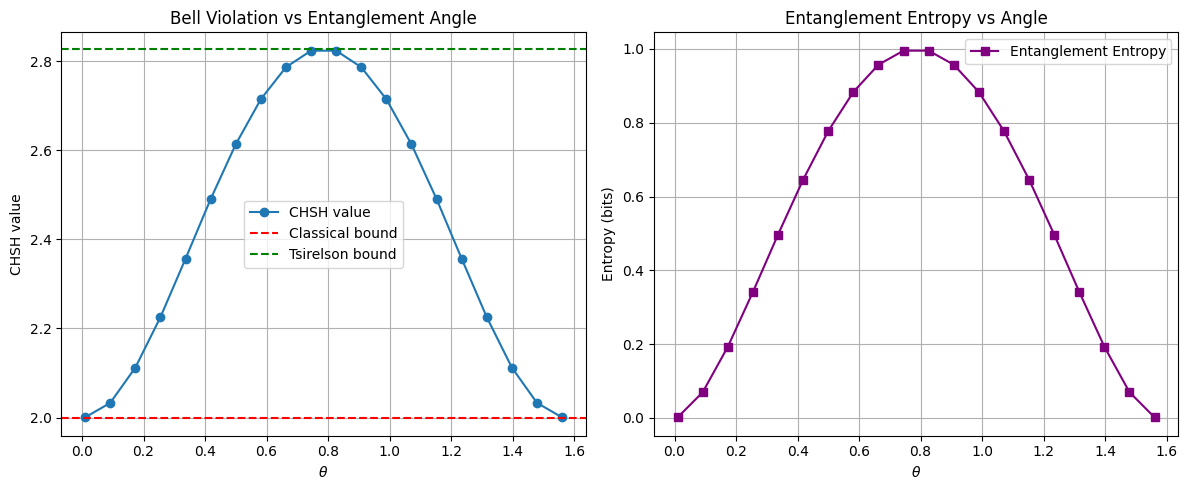

In [93]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

axs[0].plot(theta_vals, chsh_vals, 'o-', label='CHSH value')
axs[0].axhline(2, color='r', linestyle='--', label='Classical bound')
axs[0].axhline(2*np.sqrt(2), color='g', linestyle='--', label='Tsirelson bound')
axs[0].set_xlabel(r'$\theta$')
axs[0].set_ylabel('CHSH value')
axs[0].set_title('Bell Violation vs Entanglement Angle')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(theta_vals, entropy_vals, 's-', color='purple', label='Entanglement Entropy')
axs[1].set_xlabel(r'$\theta$')
axs[1].set_ylabel('Entropy (bits)')
axs[1].set_title('Entanglement Entropy vs Angle')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()